# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can fool the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.

In [1]:
%matplotlib inline

import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

## Generator network

![GAN Network](assets/gan_network.png)

Here we'll build the generator network. To make this network a universal function approximator, we'll need at least one hidden layer. We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of 0 and 1.


In [3]:
from tensorflow.keras import layers

In [36]:
def generator(n_units):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(n_units, input_shape=(100,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(784, activation="tanh"))

    return model


## Discriminator

The discriminator network is almost exactly the same as the generator network, except that we're using a sigmoid output layer.

In [37]:
def discriminator(n_units=128):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    model = tf.keras.Sequential()
    model.add(layers.Dense(n_units, input_shape=(784,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))

    return model

In [38]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [39]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [40]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Training

In [41]:
generator_model = generator(128)
generator_model.summary()
discriminator_model = discriminator(128)
discriminator_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
__________________________

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

In [82]:
batch_size = 100
epochs = 1

losses = []
samples = []

for e in range(epochs):

    for i in range(0, int(len(train_images)/batch_size), batch_size):
        
        images =  train_images[i:i+batch_size]

        images = images.reshape((images.shape[0], 784))
        images = (images - 127.5)/127.5

        noise = tf.random.normal([batch_size, 100]).numpy()

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_images = generator_model(noise, training=True)
            
            real_output = discriminator_model(images, training=True)
            fake_output = discriminator_model(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        print(gen_loss, disc_loss)        
        losses.append((disc_loss, gen_loss))
        
        gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))



    print(f"Epoch {e+1} completed!")


tf.Tensor(9.942665, shape=(), dtype=float32) tf.Tensor(0.23814884, shape=(), dtype=float32)
tf.Tensor(10.854183, shape=(), dtype=float32) tf.Tensor(0.17510632, shape=(), dtype=float32)
tf.Tensor(11.067531, shape=(), dtype=float32) tf.Tensor(0.13845319, shape=(), dtype=float32)
tf.Tensor(11.099671, shape=(), dtype=float32) tf.Tensor(0.12233853, shape=(), dtype=float32)
tf.Tensor(11.120842, shape=(), dtype=float32) tf.Tensor(0.12604454, shape=(), dtype=float32)
tf.Tensor(11.074383, shape=(), dtype=float32) tf.Tensor(0.15381753, shape=(), dtype=float32)
Epoch 1 completed!


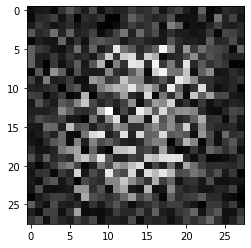

In [56]:

noise = tf.random.normal([1, 100])
predictions = generator_model(noise, training=False)

plt.imshow(np.array(predictions[0,:].numpy().reshape(28,28)*127.5 + 127.5, dtype=np.int32),
                 cmap='gray')

## Training loss

Here we'll check out the training losses for the generator and discriminator.

In [57]:
%matplotlib inline

import matplotlib.pyplot as plt

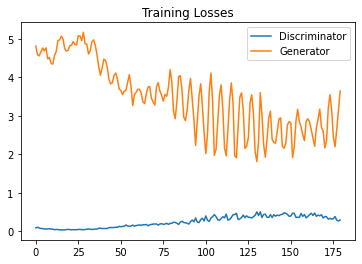

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

In [14]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 5, 7, 3, 0, 9. Since this is just a sample, it isn't representative of the full range of images this generator can make.

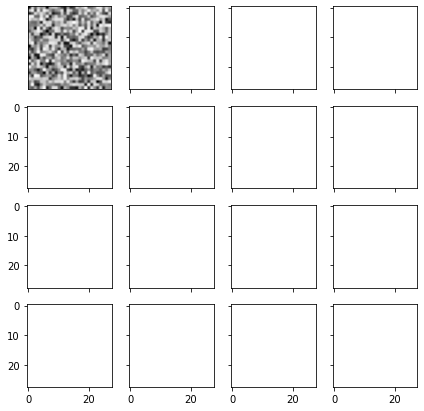

In [17]:
_ = view_samples(5, samples)

Below I'm showing the generated images as the network was training, every 10 epochs. With bonus optical illusion!

ValueError: slice step cannot be zero

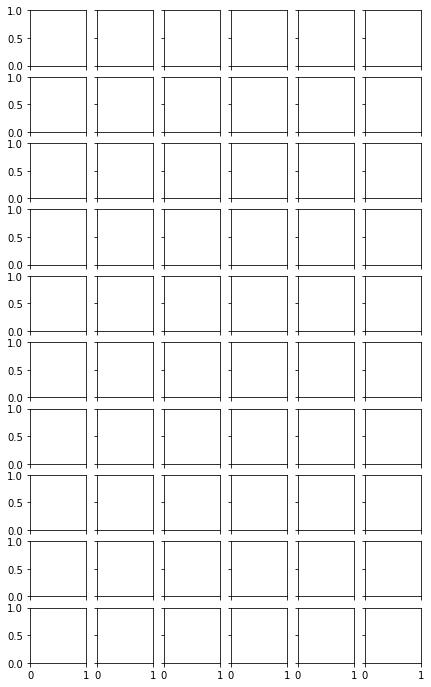

In [16]:
rows, cols = 10, 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise. Looks like 1, 9, and 8 show up first. Then, it learns 5 and 3.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector $z$ and we'll get new samples!

In [ ]:
noise = tf.random.normal([1, 784])
gen_img = generator(noise, training=False)
gen_img = gen_img.reshape((28,28))
